# TITLE

Authors: Shiva Peri, Hima Gururaj, Nikolas Diamant

Code References:
[Mesh to SDF](https://github.com/marian42/mesh_to_sdf),
[DeepSDF](https://github.com/facebookresearch/DeepSDF),

#### Importing Libraries

In [1]:
# use these specific versions so pytorch3d doesnt break

!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
%matplotlib inline

import os
import sys
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.distributions.bernoulli import Bernoulli

from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [3]:
import pytorch3d

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-05-07 02:50:55--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-05-07 02:50:55 (26.9 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [5]:
!pip install mesh-to-sdf

from mesh_to_sdf import mesh_to_voxels

import trimesh
import skimage

     |████████████████████████████████| 1.2 MB 8.8 MB/s 
     |████████████████████████████████| 978 kB 48.4 MB/s 
     |████████████████████████████████| 2.2 MB 52.6 MB/s 
     |████████████████████████████████| 646 kB 40.2 MB/s 
  Created wheel for pyopengl: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=554b37e00b7940a502ca4b48d9a87a3312164069e2f175158106608ec3af7e48
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
Successfully built pyopengl
  Attempting uninstall: pyopengl
    Found existing installation: PyOpenGL 3.1.6
    Uninstalling PyOpenGL-3.1.6:
      Successfully uninstalled PyOpenGL-3.1.6


#### Data Loader

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# load all that we need

In [ ]:
# data loader

# TODO
class SDFDataLoader(DataLoader):
    
    def __init__(self, dataset, batch_size, shuffle=True, seq_len=3):
        pass

    def __len__(self):
        pass

    def __getitem__(self, index):
        pass


#### Model Architecture

In [ ]:
# Modified DeepSDF decoder from https://github.com/facebookresearch/DeepSDF/blob/main/networks/deep_sdf_decoder.py

# TODO: implement Lipschitz regularization
class Lipschitz(nn.Module):
    def __init__(self):
        super(Lipschitz, self).__init__()
        
    def forward(self, inp):
        pass


# TODO: add Lipschitz to Decoder
class DeepSDFDecoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(DeepSDFDecoder, self).__init__()

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return 

In [ ]:
# PointNet feature code from https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

In [ ]:
# model

# potentially another architecture to try out
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
    def forward(self, inp):
        pass


# from https://arxiv.org/pdf/2202.08345v1.pdf paper
class AutoDecoder(nn.Module):
    def __init__(self, p=0.5):
        super(AutoDecoder, self).__init__()
        self.enc = PointNetfeat()
        self.dec = DeepSDFDecoder()
        
    def forward(self, inp):
        out = self.enc(inp)
        out = self.dec(out)
        return out

#### Training + Evaluation

In [ ]:
# model trainer

class Trainer:
    def __init__(self, model, loader, lr=0.1, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        # TODO: try: Dirichlet energy, chamfer loss

    # TODO: revisit
    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        for batch_num, inp in enumerate(self.loader):
            epoch_loss += self.train_batch(inp)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    # TODO: revisit
    def train_batch(self, inputs):
        
        self.optimizer.zero_grad()
        outputs, _ = self.model(inputs)
        outputs = outputs.permute(0, 2, 1)

        # since we are training an autoencoder, the input is the target
        loss = self.criterion(outputs, inputs)
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    
    def test(self):
        self.model.eval() # set to eval mode
        # predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        # self.predictions.append(predictions)
        # generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        # generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        # nll = test_prediction(predictions, fixtures_pred['out'])
        # generated = test_generation(fixtures_gen, generated_logits, vocab)
        # generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        # self.val_losses.append(nll)
        
        # self.generated.append(generated)
        # self.generated_test.append(generated_test)
        # self.generated_logits.append(generated_logits)
        # self.generated_logits_test.append(generated_logits_test)
        
        # # generate predictions for test data
        # predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        # self.predictions_test.append(predictions_test)
            
        # print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
        #               % (self.epochs, self.max_epochs, nll))
        # return nll
        pass

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        # np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        # np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        # np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        # np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        # with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
        #     fw.write(self.generated[-1])
        # with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
        #     fw.write(self.generated_test[-1])


In [ ]:
# TODO: define other hyperparameters here

P = 0.2
LR = 0.1
NUM_EPOCHS = 10
BATCH_SIZE = 256


In [ ]:
# generate unique run id
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

# initialize models
model = AutoDecoder()
loader = SDFDataLoader(dataset=dataset, batch_size=BATCH_SIZE)
trainer = Trainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id, lr=LR)

In [ ]:
# Training Loop

best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()
    

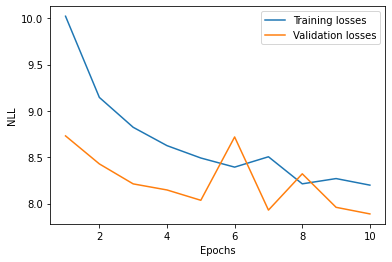

In [ ]:
# plot training curves

plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# see generated output
print (trainer.generated[-1]) # get last generated output